## Домашнее задание 1

### Обучаем LightFM бейзлайн

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.special as sp

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
data = pd.read_csv("/Users/n.anokhin/Downloads/train.csv")

data = data[data["time"] > 0.75].copy()

data["test"] = np.random.random(len(data)) > 0.8

data.head()

,user,track,time,test
0,ee8621197232afef4ae573079d64480ba7640c9eb91a7e...,41378,1.0,False
2,be3d629f02589a093027c0b917aa7668f22b2f89e83328...,1263,0.8,True
6,0457c48d8fc39719542ac36d4b3ae96327a4b842709432...,1333,1.0,False
13,13c9370b295bef6567cbfc8586a3fd67c33c79581faf1e...,1635,1.0,False
23,5714f0813b1aeaab7c5cbb9dba6b0121e8279249ccb6d1...,6849,1.0,False


In [3]:
user_counts = data.loc[~data["test"], "user"].value_counts()
users = set(user_counts[user_counts >= 5].index.values)

len(users)

10000

In [4]:
track_counts = data.loc[~data["test"], "track"].value_counts()
tracks = set(track_counts[track_counts >= 3].index.values)

len(tracks)

22333

In [5]:
train_data = data[~data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]
test_data = data[data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]

len(train_data), len(test_data)

(201806, 45790)

In [6]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [7]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [8]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]


In [9]:
best_params = {
    'loss': 'warp',
    'no_components': 50,
    'learning_rate': 0.01,
    'max_sampled': 100,
    'user_alpha': 0.0,
    'item_alpha': 0.01
}

In [10]:
model, precisions_at = fit_model(
    epochs=150,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.00976130086928606 +/- 0.0006934697580381204
1:	0.012148299254477024 +/- 0.0008020147459773475
2:	0.014982224442064762 +/- 0.0009119403226215843
3:	0.019248349592089653 +/- 0.0010361111080241904
4:	0.02353478968143463 +/- 0.001151955312084622
5:	0.026978163048624992 +/- 0.0012407144129772058
6:	0.02970035746693611 +/- 0.00129665750684987
7:	0.03239208087325096 +/- 0.0013415014357953338
8:	0.035540882498025894 +/- 0.0014054855151056829
9:	0.038496699184179306 +/- 0.001452032569950019
10:	0.04108684882521629 +/- 0.0014993175675230926
11:	0.0437074713408947 +/- 0.0015337197687510231
12:	0.046307772397994995 +/- 0.0015661436241154348
13:	0.04855256900191307 +/- 0.0016011061260949213
14:	0.0508786216378212 +/- 0.0016270523042914216
15:	0.05321483314037323 +/- 0.0016584912548411725
16:	0.05520569533109665 +/- 0.0016863991479621517
17:	0.05763331800699234 +/- 0.001713369085556557
18:	0.05948197469115257 +/- 0.0017318754941204964
19:	0.061635345220565796 +/- 0.0017536237583856504
20:	0.063

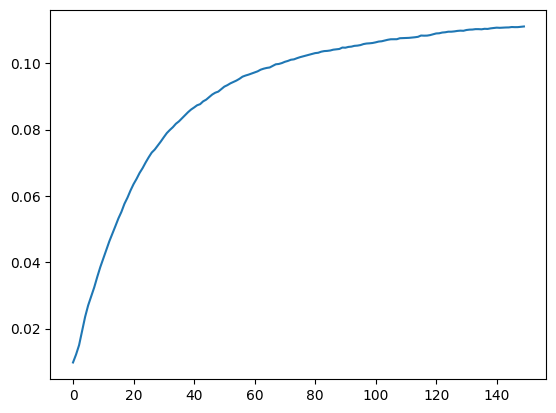

In [11]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

### Готовим данные для сабмита

In [12]:
submit_data = pd.read_csv("/Users/n.anokhin/Downloads/test.csv")
submit_data.head()

,user,track
0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,4218
1,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,19007
2,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,346
3,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,8822
4,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,29271


In [13]:
filtered_submit_data = submit_data[submit_data["user"].isin(users) & submit_data["track"].isin(tracks)].copy()

In [14]:
filtered_submit_data["score"] = model.predict(
    filtered_submit_data["user"].map(dataset.mapping()[0]).values,
    filtered_submit_data["track"].map(dataset.mapping()[2]).values,
)

<Axes: xlabel='score', ylabel='Count'>

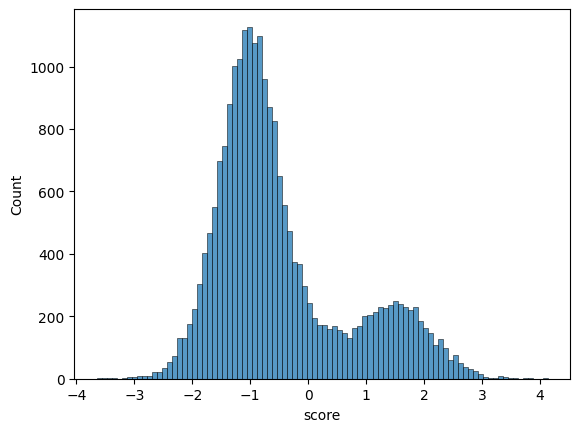

In [15]:
sns.histplot(filtered_submit_data["score"])

In [16]:
scored_submit_data = pd.merge(
    submit_data,
    filtered_submit_data,
    left_on=["user", "track"],
    right_on=["user", "track"],
    how="left"
)

# Fill missing scores with small random numbers
scored_submit_data["score"] = scored_submit_data["score"].map(lambda s : np.random.random() * 0.05 if pd.isna(s) else s)

scored_submit_data.head()

,user,track,score
0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,4218,1.034645
1,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,19007,-1.862102
2,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,346,-1.352723
3,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,8822,0.015543
4,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,29271,0.016366


In [17]:
scored_submit_data.to_csv("/Users/n.anokhin/Desktop/submit.csv", index=False)

In [18]:
%%sh 
head /Users/n.anokhin/Desktop/submit.csv

user,track,score
6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b,4218,1.0346451997756958
6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b,19007,-1.8621021509170532
6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b,346,-1.3527225255966187
6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b,8822,0.015542619011862697
6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b,29271,0.016366001890425346
6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b,43736,0.042496463939189794
4e07408562bedb8b60ce05c1decfe3ad16b72230967de01f640b7e4729b49fce,2298,0.8773146271705627
4e07408562bedb8b60ce05c1decfe3ad16b72230967de01f640b7e4729b49fce,837,-0.6583950519561768
4e07408562bedb8b60ce05c1decfe3ad16b72230967de01f640b7e4729b49fce,33028,0.0036338878051496494
